In [12]:
try:
    spark
    print("Using existing SparkSession.")
except NameError:
    print("No SparkSession found. Installing pyspark + delta-spark and configuring...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyspark==3.5.0", "delta-spark==3.1.0"])
    from pyspark.sql import SparkSession
    from delta import configure_spark_with_delta_pip
    builder = (
        SparkSession.builder.appName("DeltaRideHailing")
        .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
    )
    spark = configure_spark_with_delta_pip(builder).getOrCreate()

from pyspark.sql import functions as F, types as T
spark.sql("set spark.sql.shuffle.partitions=8")
print("Spark version:", spark.version)


Using existing SparkSession.
Spark version: 3.5.0


In [33]:
import datetime

trip_schema = T.StructType([
    T.StructField("trip_id",      T.IntegerType()),
    T.StructField("rider_id",     T.StringType()),
    T.StructField("driver_id",    T.StringType()),
    T.StructField("city",         T.StringType()),
    T.StructField("distance_km",  T.DoubleType()),
    T.StructField("fare",         T.DoubleType()),
    T.StructField("tip",          T.DoubleType()),
    T.StructField("ts",           T.TimestampType()),
])
driver_schema = T.StructType([
    T.StructField("driver_id",   T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating",      T.DoubleType()),
    T.StructField("vehicle",     T.StringType()),
])

trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, datetime.datetime(2025, 8, 8, 8, 5, 0)),
    (1002,"R002","D011","Hyderabad",  6.2, 150.0, 10.0, datetime.datetime(2025, 8, 8, 8, 15, 0)),
    (1003,"R003","D012","Pune",       3.5,  90.0,  0.0, datetime.datetime(2025, 8, 8, 8, 20, 0)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, datetime.datetime(2025, 8, 8, 8, 45, 0)),
    (1005,"R004","D013","Chennai",   10.0, 260.0, 15.0, datetime.datetime(2025, 8, 8, 9, 5, 0)),
    (1006,"R005","D012","Pune",       2.2,  70.0,  0.0, datetime.datetime(2025, 8, 8, 9, 10, 0)),
]
drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz"),
]

In [34]:
trips_df   = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print("  Trips  ->", TRIPS_PATH)
print("  Drivers->", DRIVERS_PATH)

Seeded:
  Trips  -> /tmp/delta/ride_hailing/trips
  Drivers-> /tmp/delta/ride_hailing/drivers


In [35]:
spark.sql("drop table if exists trips_managed")
spark.sql("drop table if exists drivers_ext")

DataFrame[]

In [36]:
spark.sql(f'''
  create table trips_managed
  using delta
  as select * from delta.`{TRIPS_PATH}`
''')

DataFrame[]

In [37]:
spark.sql(f'''
  create table drivers_ext
  using delta
  location '{DRIVERS_PATH}'
''')

DataFrame[]

In [41]:
print("DESCRIBE DETAIL trips_managed")
spark.sql("describe detail trips_managed").show(truncate=False)

print("DESCRIBE DETAIL drivers_ext")
spark.sql("describe detail drivers_ext").show(truncate=False)

print('''
Difference:
- Managed: data stored under metastore location; dropping the table deletes data.
- External: just a pointer to path; drop does NOT delete files at that path.
''')


DESCRIBE DETAIL trips_managed
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |b47c64dd-9440-4001-ab11-def0ccf99f08|spark_catalog.default.trips_managed|NULL   

In [49]:
df_trips   = spark.table("trips_managed")
df_drivers = spark.table("drivers_ext")

df_trips.printSchema()
df_drivers.printSchema()

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)



In [50]:
print("Trips (10 rows):")
df_trips.show(10, truncate=False)

print("Derived column total_amount = fare + tip; top 5 by total_amount")
df_trips = df_trips.withColumn("total_amount", F.col("fare") + F.col("tip"))
df_trips.orderBy(F.col("total_amount").desc()).show(5, truncate=False)

Trips (10 rows):
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Derived column total_amount = fare + tip; top 5 by total_amount
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|tr

In [51]:
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, "trips_managed")

print("Before (affected rows):")
spark.sql('''
  select trip_id, city, distance_km, fare, tip
  from trips_managed
  where city='Bengaluru' and distance_km > 15
''').show(truncate=False)

Before (affected rows):
+-------+---------+-----------+-----+----+
|trip_id|city     |distance_km|fare |tip |
+-------+---------+-----------+-----+----+
|1004   |Bengaluru|18.9       |480.0|25.0|
+-------+---------+-----------+-----+----+



In [52]:
dt.update(
    condition="city = 'Bengaluru' AND distance_km > 15",
    set={"tip": F.col("tip") + F.lit(5.0)}
)

print("After (affected rows):")
spark.sql('''
  select trip_id, city, distance_km, fare, tip
  from trips_managed
  where city='Bengaluru' and distance_km > 15
''').show(truncate=False)

After (affected rows):
+-------+---------+-----------+-----+----+
|trip_id|city     |distance_km|fare |tip |
+-------+---------+-----------+-----+----+
|1004   |Bengaluru|18.9       |480.0|30.0|
+-------+---------+-----------+-----+----+



In [53]:
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, "trips_managed")
before = spark.table("trips_managed").count()
dt.delete("fare <= 0 OR distance_km <= 0")
after = spark.table("trips_managed").count()
print(f"Rows before: {before}, after delete: {after}")

Rows before: 6, after delete: 6


In [59]:
import datetime
from pyspark.sql import functions as F

new_rows = [
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 35.0, datetime.datetime(2025, 8, 8, 8, 45, 0)),  # corrected tip
    (1007,"R006","D013","Chennai",   12.0, 300.0, 20.0, datetime.datetime(2025, 8, 8, 9, 30, 0)),  # new
]
batch_df = spark.createDataFrame(new_rows, schema=trip_schema)

In [66]:
dt = DeltaTable.forName(spark, "trips_managed")
(
    dt.alias("t")
    .merge(batch_df.alias("s"), "t.trip_id = s.trip_id")
    .whenMatchedUpdateAll()
    .whenNotMatchedInsertAll()
    .execute()
)

In [74]:

spark.sql("select * from trips_managed where trip_id in (1004,1007) order by trip_id").show(truncate=False)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|35.0|2025-08-08 08:45:00|
|1007   |R006    |D013     |Chennai  |12.0       |300.0|20.0|2025-08-08 09:30:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [76]:
spark.sql("drop view if exists gold_trips")




DataFrame[]

In [77]:
spark.sql('''
create view gold_trips as
select
  t.trip_id,
  t.city,
  d.driver_name,
  d.rating,
  t.distance_km,
  (t.fare + t.tip) as total_amount,
  t.ts
from trips_managed t
join drivers_ext d
  on t.driver_id = d.driver_id
''')

DataFrame[]

In [83]:
print("City-wise total revenue and avg driver rating:")
spark.sql('''
  select city,
         round(sum(total_amount),2) as total_revenue,
         round(avg(rating),2) as avg_driver_rating
  from gold_trips
  group by city
  order by total_revenue desc
''').show(truncate=False)


City-wise total revenue and avg driver rating:
+---------+-------------+-----------------+
|city     |total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|Bengaluru|855.0        |4.8              |
|Chennai  |595.0        |4.9              |
|Pune     |160.0        |4.4              |
|Hyderabad|160.0        |4.6              |
+---------+-------------+-----------------+



In [89]:
print("Driver-wise total trips and top 3 drivers by revenue:")
spark.sql('''
  with driver_revenue as (
    select driver_name, count(*) as total_trips, round(sum(total_amount),2) as revenue
    from gold_trips
    group by driver_name
  )
  select * from driver_revenue
  order by revenue desc
  limit 3
''').show(truncate=False)

Driver-wise total trips and top 3 drivers by revenue:
+-----------+-----------+-------+
|driver_name|total_trips|revenue|
+-----------+-----------+-------+
|Anil       |2          |855.0  |
|Meera      |2          |595.0  |
|Rakesh     |2          |160.0  |
+-----------+-----------+-------+



In [93]:
print("DESCRIBE HISTORY trips_managed")
spark.sql("describe history trips_managed").show(truncate=False)

DESCRIBE HISTORY trips_managed
+-------+-----------------------+------+--------+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-

In [96]:
latest_count = spark.table("trips_managed").count()
asof0 = spark.read.format("delta").option("versionAsOf", 0).table("trips_managed")
asof0_count = asof0.count()
print("Counts → latest:", latest_count, " | version 0:", asof0_count)

Counts → latest: 7  | version 0: 6


In [101]:
print("Sample rows from version 0:")
asof0.show(5, truncate=False)

Sample rows from version 0:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
only showing top 5 rows



In [102]:
PARTITIONED_PATH = "/tmp/delta/ride_hailing/trips_partitioned_by_city"
spark.sql("drop table if exists trips_by_city_part")

spark.read.table("trips_managed")\
    .write.format("delta").mode("overwrite").partitionBy("city").save(PARTITIONED_PATH)

In [105]:
spark.sql("drop table if exists trips_by_city_part")


DataFrame[]

In [106]:
spark.sql(f'''
  create table trips_by_city_part
  using delta
  location '{PARTITIONED_PATH}'
''')

DataFrame[]

In [110]:
print("Filter on Bengaluru (partition pruning expected):")
spark.sql("select * from trips_by_city_part where city='Bengaluru'").show(truncate=False)

Filter on Bengaluru (partition pruning expected):
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|35.0|2025-08-08 08:45:00|
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [112]:
import datetime
from pyspark.sql import functions as F

incr_rows = [
    (1008,"R007","D010","Mumbai",  7.5, 180.0, 10.0, datetime.datetime(2025, 8, 8, 10, 10, 0)),
    (1009,"R008","D011","Mumbai", 15.0, 380.0, 25.0, datetime.datetime(2025, 8, 8, 10, 20, 0)),
]
incr_df = spark.createDataFrame(incr_rows, schema=trip_schema)
incr_df.write.format("delta").mode("append").saveAsTable("trips_managed")

In [120]:
print("City-wise revenue after incremental load:")
spark.sql('''
  select city, round(sum(fare+tip),2) as total_revenue
  from trips_managed
  group by city
  order by total_revenue desc
''').show(truncate=False)

City-wise revenue after incremental load:
+---------+-------------+
|city     |total_revenue|
+---------+-------------+
|Bengaluru|855.0        |
|Chennai  |595.0        |
|Mumbai   |595.0        |
|Pune     |160.0        |
|Hyderabad|160.0        |
+---------+-------------+



In [129]:
stream_source = spark.readStream.format("delta").load("/tmp/delta/ride_hailing/trips")

query = (
    stream_source.writeStream
    .format("console")
    .outputMode("append")
    .option("truncate", False)
    .trigger(processingTime='5 seconds')
    .start()
)

In [130]:
import time
import datetime
from pyspark.sql import functions as F

time.sleep(10)

more_rows = [
    (1010,"R009","D012","Mumbai", 4.1, 110.0, 5.0, datetime.datetime(2025, 8, 8, 10, 35, 0)),
]
more_df = spark.createDataFrame(more_rows, schema=trip_schema)
more_df.write.format("delta").mode("append").save("/tmp/delta/ride_hailing/trips")

print("Appended a new row. Wait a few seconds to see it in the console sink...")
time.sleep(10)

query.stop()
print("Streaming stopped.")

Appended a new row. Wait a few seconds to see it in the console sink...
Streaming stopped.


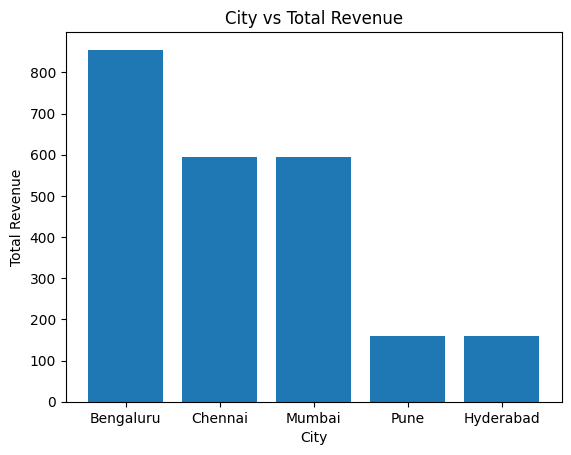

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

city_pdf = spark.sql('''
  select city, sum(total_amount) as total_revenue
  from gold_trips
  group by city
  order by total_revenue desc
''').toPandas()

plt.figure()
plt.bar(city_pdf["city"], city_pdf["total_revenue"])
plt.title("City vs Total Revenue")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.show()


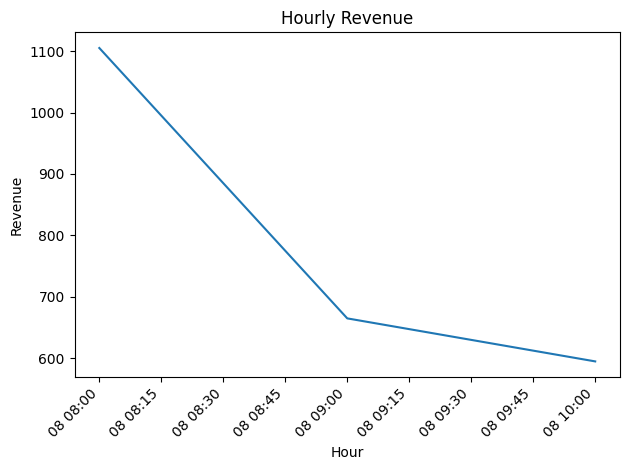

In [139]:
hourly_pdf = spark.sql('''
  select date_trunc('hour', ts) as hour, sum(total_amount) as hourly_revenue
  from gold_trips
  group by date_trunc('hour', ts)
  order by hour
''').toPandas()

plt.figure()
plt.plot(hourly_pdf["hour"], hourly_pdf["hourly_revenue"])
plt.title("Hourly Revenue")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [140]:

spark.sql("drop table if exists trips_managed")
spark.sql("drop table if exists drivers_ext")
print("Dropped trips_managed (managed) and drivers_ext (external).")

print("Recreating tables for subsequent tasks that rely on them...")

Dropped trips_managed (managed) and drivers_ext (external).
Recreating tables for subsequent tasks that rely on them...


In [141]:
spark.sql(f'''
  create table trips_managed
  using delta
  as select * from delta.`/tmp/delta/ride_hailing/trips`
''')

DataFrame[]

In [142]:
spark.sql(f'''
  create table drivers_ext
  using delta
  location '/tmp/delta/ride_hailing/drivers'
''')


DataFrame[]

In [144]:
import datetime
from pyspark.sql import functions as F

bad_rows = [
    (2001,"R010","D010","Chennai", 5.0, 120.0, -5.0, datetime.datetime(2025, 8, 8, 11, 0, 0)),
]
bad_df = spark.createDataFrame(bad_rows, schema=trip_schema)

In [145]:
print("Attempt to write bad data with tip < 0 — we'll block via filter:")
clean_df = bad_df.filter("tip >= 0")
if clean_df.count() == 0:
    print("All rows rejected (tip >= 0 rule). Nothing written.")
else:
    clean_df.write.format("delta").mode("append").saveAsTable("trips_managed")
    print("Clean rows written.")


Attempt to write bad data with tip < 0 — we'll block via filter:
All rows rejected (tip >= 0 rule). Nothing written.


In [146]:
PARQUET_PATH = "/tmp/delta/ride_hailing/trips_parquet_subset"

subset_df = spark.table("trips_managed").limit(3)
subset_df.write.mode("overwrite").parquet(PARQUET_PATH)

spark.sql("drop table if exists trips_from_parquet")
spark.sql(f"convert to delta parquet.`{PARQUET_PATH}`")

spark.sql(f'''
  create table trips_from_parquet
  using delta
  location '{PARQUET_PATH}'
''')


DataFrame[]

In [159]:
from delta.tables import DeltaTable
dtp = DeltaTable.forPath(spark, PARQUET_PATH)

up_df = subset_df.limit(1).withColumn("tip", F.col("tip") + F.lit(2.0))

(
    dtp.alias("t")
    .merge(up_df.alias("s"), "t.trip_id = s.trip_id")
    .whenMatchedUpdateAll()
    .whenNotMatchedInsertAll()
    .execute()
)


In [171]:
print("History of trips_from_parquet after merge:")
spark.sql("describe history trips_from_parquet").show(truncate=False)

History of trips_from_parquet after merge:
+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+--

In [189]:
import pandas as pd
import matplotlib.pyplot as plt

total_rev = spark.sql("select round(sum(fare+tip),2) as total_revenue from trips_managed").first()["total_revenue"]
print("Total Revenue:", total_rev)

Total Revenue: 1670.0


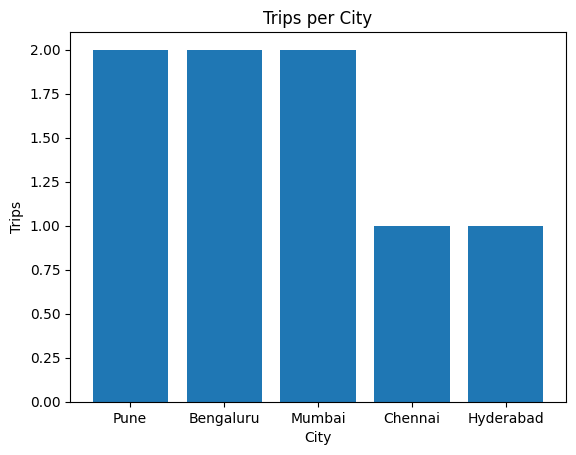

In [208]:
city_pdf = spark.sql('''
  select city, count(*) as trips, round(sum(fare+tip),2) as revenue
  from trips_managed
  group by city
  order by trips desc
''').toPandas()

plt.figure()
plt.bar(city_pdf["city"], city_pdf["trips"])
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Trips")
plt.show()

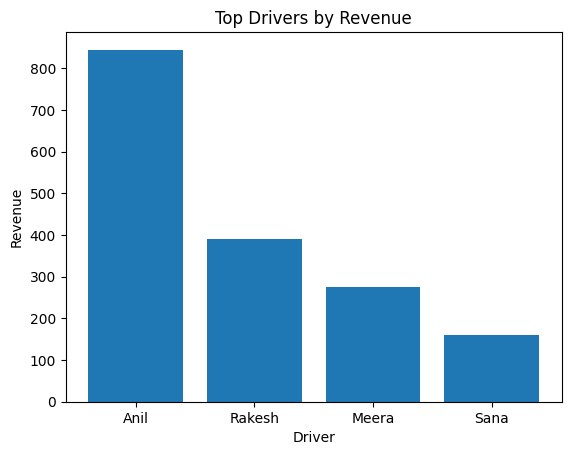

In [226]:
drivers_pdf = spark.sql('''
  select d.driver_name, round(sum(t.fare+t.tip),2) as revenue
  from trips_managed t
  join drivers_ext d on t.driver_id=d.driver_id
  group by d.driver_name
  order by revenue desc
''').toPandas()

plt.figure()
plt.bar(drivers_pdf["driver_name"], drivers_pdf["revenue"])
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.show()

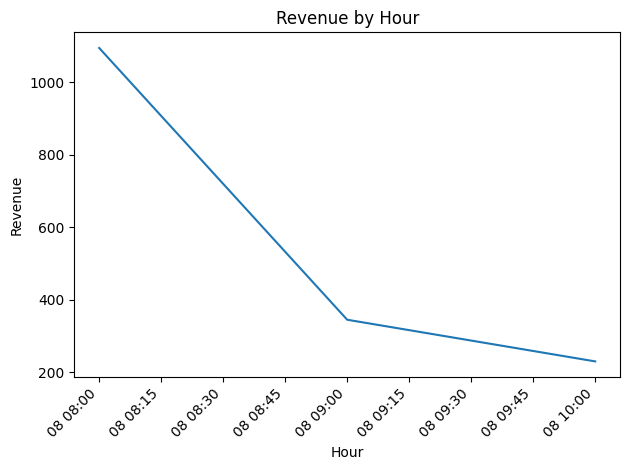

In [244]:
hourly_pdf = spark.sql('''
  select date_trunc('hour', ts) as hour, sum(fare+tip) as revenue
  from trips_managed
  group by date_trunc('hour', ts)
  order by hour
''').toPandas()

plt.figure()
plt.plot(hourly_pdf["hour"], hourly_pdf["revenue"])
plt.title("Revenue by Hour")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
